<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = pd.read_csv('Arousal_frames_emodb.csv')

In [6]:
y = y.iloc[:,[1]]

In [7]:
y_8000_rows = y[0:10000]
#y = y[0:14276]

In [8]:
y_arr = y_8000_rows.to_numpy()
#y_arr = y.to_numpy()

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [ ]:
chunk = 100
i=0
X=[]
import pandas as pd
for df in pd.read_csv('X_matrix.csv',chunksize = chunk):
    X.append(df)
    i=i+1
    print('Processed {i}/120 chunks'.format(i=i))
    if i == 100:
      break
   



Processed 1/120 chunks
Processed 2/120 chunks
Processed 3/120 chunks
Processed 4/120 chunks
Processed 5/120 chunks
Processed 6/120 chunks
Processed 7/120 chunks
Processed 8/120 chunks
Processed 9/120 chunks
Processed 10/120 chunks
Processed 11/120 chunks
Processed 12/120 chunks
Processed 13/120 chunks
Processed 14/120 chunks
Processed 15/120 chunks
Processed 16/120 chunks
Processed 17/120 chunks
Processed 18/120 chunks
Processed 19/120 chunks
Processed 20/120 chunks
Processed 21/120 chunks
Processed 22/120 chunks
Processed 23/120 chunks
Processed 24/120 chunks
Processed 25/120 chunks
Processed 26/120 chunks
Processed 27/120 chunks
Processed 28/120 chunks
Processed 29/120 chunks
Processed 30/120 chunks
Processed 31/120 chunks
Processed 32/120 chunks
Processed 33/120 chunks
Processed 34/120 chunks
Processed 35/120 chunks
Processed 36/120 chunks
Processed 37/120 chunks
Processed 38/120 chunks
Processed 39/120 chunks
Processed 40/120 chunks
Processed 41/120 chunks
Processed 42/120 chunks
P

In [ ]:
X = pd.concat(X)

In [ ]:
del X [X.columns[0]]

In [ ]:
X_arr = X.to_numpy()

In [ ]:
X_arr.shape

In [ ]:
X_arr = np.reshape(X_arr,(10000,224,224))

In [ ]:
X_arr.shape

In [ ]:
import gc

In [ ]:
del X
gc.collect

Adding new dimension for CNN

In [ ]:
X_ = X_arr[:,:,np.newaxis]

In [ ]:
X_ = np.swapaxes(X_,2,1)

In [ ]:
X_.shape

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_,y_arr,test_size=0.2,random_state=42)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2,random_state=42)

Clear variables that are not in use anymore

In [ ]:
import gc

In [ ]:
del X_
gc.collect()
del X_arr
gc.collect()

In [ ]:
del y_arr
gc.collect()

Converting X to appropriate Datatype...

In [ ]:
X_tensor_train = torch.from_numpy(X_train)
X_tensor_test = torch.from_numpy(X_test)
#X_tensor_val = torch.from_numpy(X_val)

y_tensor_train = torch.from_numpy(y_train)
y_tensor_test = torch.from_numpy(y_test)
#y_tensor_val = torch.from_numpy(y_val)

In [ ]:
del X_train, X_test, y_train, y_test#, X_val, y_val
gc.collect()

In [ ]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
#X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)
#y_tensor_val = y_tensor_val.type(torch.LongTensor)

Pytorch needs the true labels to be in the range N-1. Thus, substract 1 one from each label.

In [ ]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1
#y_tensor_val = y_tensor_val-1

Loading remaining data...

In [ ]:
y_frames = y[14276:].to_numpy()

In [ ]:
y_frames.shape

In [33]:
frames = []
i = 0
for x in pd.read_csv('X_frames.csv', chunksize = 100):
  frames.append(x)
  i=i+1
  print('processing')

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing


In [34]:
frames = pd.concat(frames)

In [35]:
del frames [frames.columns[0]]

In [36]:
frames = frames.to_numpy()

In [37]:
frames.shape

(7348, 50176)

In [40]:
frames = np.reshape(frames,(7348,224,224))

In [41]:
frames = frames[:,:,np.newaxis]

In [42]:
frames = np.swapaxes(frames,2,1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(frames, y_frames, test_size = 0.2, random_state=42)

In [44]:
del frames, y_frames
gc.collect()

8

In [45]:
X_tensor_train_fr = torch.from_numpy(X_train)
X_tensor_test_fr = torch.from_numpy(X_test)

y_tensor_train_fr = torch.from_numpy(y_train)
y_tensor_test_fr = torch.from_numpy(y_test)


In [46]:
del X_train, X_test, y_train, y_test
gc.collect()

0

In [ ]:
X_tensor_train_fr = torch.tensor(X_tensor_train_fr,dtype = torch.float32)
X_tensor_test_fr = torch.tensor(X_tensor_test_fr,dtype = torch.float32)

y_tensor_train_fr = y_tensor_train_fr.type(torch.LongTensor)
y_tensor_test_fr = y_tensor_test_fr.type(torch.LongTensor)

In [47]:
y_tensor_train_fr = y_tensor_train_fr -1
y_tensor_test_fr = y_tensor_test_fr -1

In [50]:
X_tensor_train.shape

torch.Size([8000, 1, 224, 224])

In [53]:
xyz = torch.cat((X_tensor_train,X_tensor_train_fr),0)

In [55]:
del X_tensor_train, X_tensor_train_fr
gc.collect()

76

In [56]:
#X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_fr),0)
X_tensor_test_cat = torch.cat((X_tensor_test,X_tensor_test_fr),0)
del X_tensor_test, X_tensor_test_fr
gc.collect()

y_tensor_train_cat = torch.cat((y_tensor_train,y_tensor_train_fr),0)
del y_tensor_train,y_tensor_train_fr
gc.collect()
y_tensor_test_cat = torch.cat((y_tensor_test,y_tensor_test_fr),0)
del y_tensor_test, y_tensor_test_fr
gc.collect()


0

In [58]:
print('training shape X is {}, test shape X is{}'.format(xyz.shape,X_tensor_test_cat.shape))

training shape X is torch.Size([13878, 1, 224, 224]), test shape X istorch.Size([3470, 1, 224, 224])


Setup custom dataset class

In [59]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [60]:
dataset_train = SimpleDataset(xyz,y_tensor_train_cat)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

#dataset_val = SimpleDataset(X_tensor_val,y_tensor_val)
#dataloader_val = DataLoader(dataset_val,batch_size=32)

dataset_test = SimpleDataset(X_tensor_test_cat,y_tensor_test_cat)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


Setting up the CNN.

In [81]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(774400, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
#removed second layer

In [82]:
SalienceNet = CNN()
SalienceNet.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=774400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [63]:
criterion = nn.CrossEntropyLoss()

In [79]:
def analysis(net, loss_fn, dataloader_train,dataloader_test,
          epoch=100, learning_rate=0.001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    train_loss = []
   
    train_total_loss = []
    train_accuracy = []
    for i in range(epoch):
        total,correct = 0,0
        
        net.to(device)   
        net.train()
        for data, label in dataloader_train:
            data, label = data.to(device), label.to(device)
        #make prediction
            output = net(data.float())

            _, y_pred_train = torch.max(output,1) # get predicted train label

            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            loss = criterion(output,torch.max(label.long(), 1)[0])

            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient udpate.

            total += label.size(0)
            correct += (y_pred_train == torch.max(label,1)[0]).sum().item()
            
            train_loss.append(loss.item())
            print('currently processing epoch {}'.format(i))
            #print('batch accuracy of {}'.format(100*(correct/total)))
            
            #if (i + 1) % (epoch // 5) == 0:
             #print(f'iteration {i + 1}/{epoch} | loss: {loss.item():.3f}')
    

    train_accuracy.append(correct/total)

    net.eval()
    test_loss = []
    test_total,test_correct = 0,0
    test_acc = []
    for data, labels in dataloader_test:
        print('testing...')

        data, labels = data.to(device), labels.to(device)
        outputs = net(data.float())

        _, y_pred_test = torch.max(outputs,1) # get predicted label for test

        test_l = criterion(outputs,torch.max(labels.long(), 1)[0])
        test_loss.append(test_l.item())

        test_total += labels.size(0)
        test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

    print('test acc is {}'.format(test_acc))

    return train_loss,test_loss,train_accuracy,test_acc 


In [65]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [66]:
import matplotlib.pyplot as plt

In [67]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [83]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,test_loss,train_acc,test_acc=analysis(net=SalienceNet,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_test=dataloader_test,epoch=30)




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
currently processing epoch 18
cur

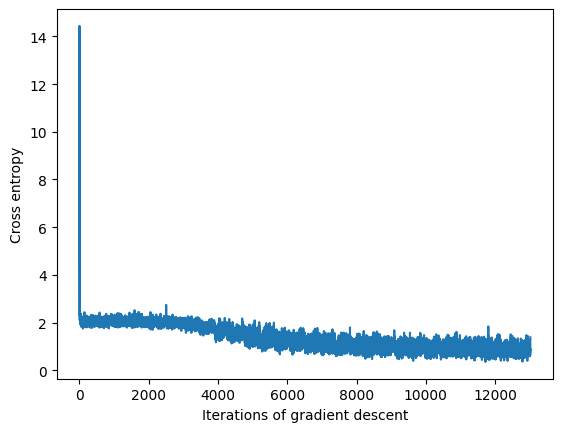

In [84]:
plt.plot(train_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.show()

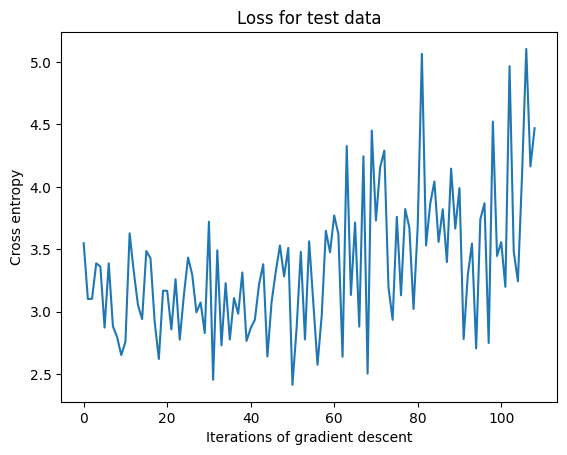

In [85]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.title('Loss for test data')
plt.show()

In [86]:
print('training accuracy is {}'.format(train_acc))
print('test accuracy is {}'.format(test_acc))

training accuracy is [0.682230869001297]
test accuracy is [0.19279538904899135]
